# Read the png Files

In [76]:
import matplotlib.pyplot as plt
import cv2 
import os
import numpy as np
import pandas as pd

In [89]:
def read_dataset(lispath, target, resize_shape=(256, 256)):
    imgs = []
    for file in os.listdir(lispath):
        if file[-3:] == 'png':
            img = cv2.imread(os.path.join(lispath, file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, resize_shape)  # Resize image to 256x256 or any desired size
            imgs.append(np.array(img))

    labels = len(imgs) * [target]
    return np.array(imgs), np.array(labels)


In [90]:
type3, labels3 = read_dataset('Type III radio burst 2022', 'Type III',resize_shape=(2066,1067))
print(np.shape(type3))


(262, 1067, 2066, 3)


In [91]:
type2, labels2 = read_dataset('Type II radio burst 2022', 'Type II',resize_shape=(2066,1067))
print(np.shape(type2))


(42, 1067, 2066, 3)


In [93]:
images = np.concatenate([type3,type2])
labels = np.concatenate([labels3,labels2])

In [95]:
images.shape

(304, 1067, 2066, 3)

In [96]:
labels.shape

(304,)

# Read the FITS files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

def read_fits_dataset(filename):
    """
    General function to read a FITS dataset, extract the data matrix, 
    frequency axis, and time axis.

    Parameters:
    filename (str): Path to the FITS file.

    Returns:
    data_matrix (np.ndarray): The 2D data array.
    freqs (np.ndarray): Frequency axis (1D array).
    time (np.ndarray): Time axis (1D array).
    """
    try:
        # Open the FITS file
        with fits.open(filename) as hdul:
            # Print FITS file info
            fits.info(filename)

            # Extract data matrix from primary HDU
            data_matrix = hdul[0].data
            
            # Extract binary table data from HDU 1 if it exists
            if len(hdul) > 1 and isinstance(hdul[1], fits.BinTableHDU):
                binary_table = hdul[1].data
                print(hdul[1].columns)  # Print available columns

                # Since the axes seem to be swapped, handle accordingly
                freqs = binary_table['FREQUENCY'][0]  # First row contains all frequency points
                time = binary_table['TIME'][0]  # First row contains all time points

            else:
                raise ValueError("Binary table not found or invalid structure.")

            # Check if data matrix dimensions match the axes (after swapping axes)
            if data_matrix.shape[0] != len(freqs) or data_matrix.shape[1] != len(time):
                raise ValueError("Data matrix dimensions do not match frequency and time axes.")
            
            return data_matrix, freqs, time

    except Exception as e:
        print(f"Error reading FITS file: {e}")
        return None, None, None

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def plot_fits_data(data_matrix, freqs, time, title_raw='Raw Spectrum', title_filtered='Filtered Spectrum', vmin=None, vmax=None):
    """
    Function to plot both the raw and filtered data matrices with frequency and time axes.

    Parameters:
    data_matrix (np.ndarray): The 2D data array to plot.
    freqs (np.ndarray): Frequency axis (1D array).
    time (np.ndarray): Time axis (1D array).
    title_raw (str): Title for the raw spectrum plot.
    title_filtered (str): Title for the filtered spectrum plot.
    vmin (float): Minimum value for color scaling (optional).
    vmax (float): Maximum value for color scaling (optional).
    """
    # Plot the raw spectrum
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)  # Create a subplot for side-by-side plots
    plt.imshow(data_matrix, aspect='auto', extent=[time[0], time[-1], freqs[0], freqs[-1]], origin='lower')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (MHz)')
    plt.colorbar()
    plt.title(title_raw)
    
    # Optional: Adjust color scaling for better visualization of raw data
    if vmin is not None and vmax is not None:
        plt.clim(vmin, vmax)
    
    # Compute background as the mean along the time axis
    background = np.mean(data_matrix, axis=1)  # Mean across time axis (for each frequency band)
    background = np.tile(background, (data_matrix.shape[1], 1)).T  # Expand to match data_matrix size

    # Subtract background to get filtered data
    filtered_data = data_matrix - background
    
    # Clip the filtered data to a certain range (optional)
    filtered_data = np.clip(filtered_data, -1, 25)  # Adjust clipping range as needed

    # Plot the filtered spectrum
    plt.subplot(1, 2, 2)  # Second plot for the filtered spectrum
    plt.imshow(filtered_data, aspect='auto', extent=[time[0], time[-1], freqs[0], freqs[-1]], origin='lower')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (MHz)')
    plt.colorbar()
    plt.title(title_filtered)

    # Optional: Adjust color scaling for better visualization of filtered data
    if vmin is not None and vmax is not None:
        minValue = np.min(filtered_data)
        maxValue = np.max(filtered_data)
        plt.clim(minValue, maxValue)

    # Show both plots
    plt.tight_layout()
    plt.show()



Filename: ALASKA-COHOE_20220108_230000_01.fit\c_\CALLISTO-01\FITfiles\ALASKA-COHOE_20220108_230000_01.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      40   (3600, 200)   uint8   
  1                1 BinTableHDU     16   1R x 2C   [3600D8.3, 200D8.3]   
ColDefs(
    name = 'TIME'; format = '3600D8.3'; bscale = 1.0; bzero = 0.0
    name = 'FREQUENCY'; format = '200D8.3'; bscale = 1.0; bzero = 0.0
)


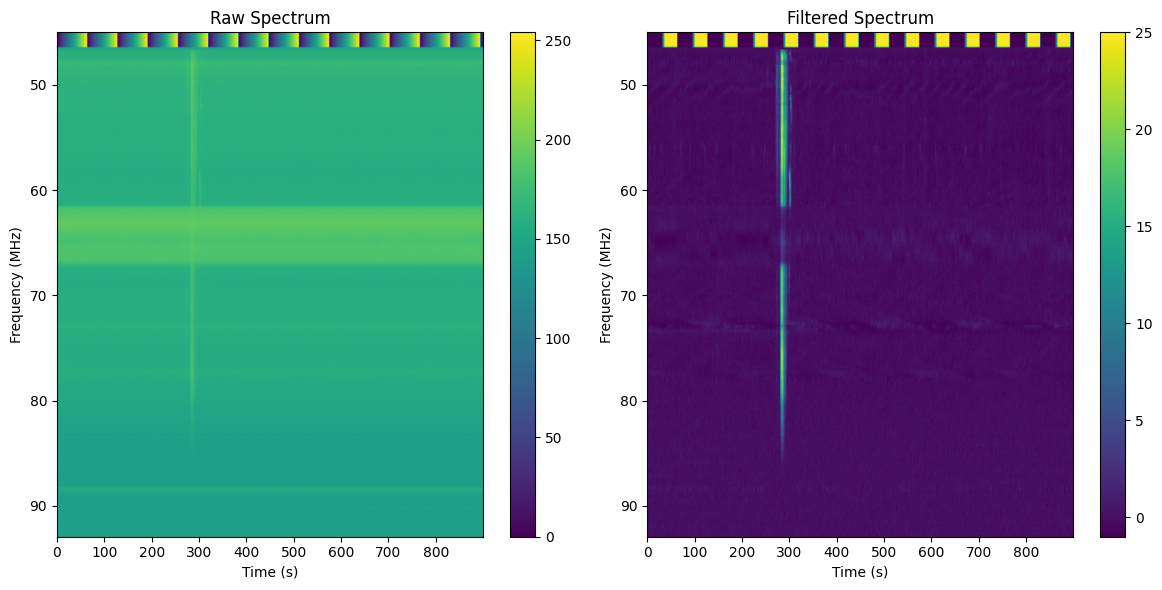

In [3]:
# Example usage:
filename = 'ALASKA-COHOE_20220108_230000_01.fit\c_\CALLISTO-01\FITfiles\ALASKA-COHOE_20220108_230000_01.fit'
data_matrix, freqs, time = read_fits_dataset(filename)

if data_matrix is not None:
    plot_fits_data(data_matrix, freqs, time)